<a href="https://colab.research.google.com/github/AndrewSLowe/DS-Unit-2-Kaggle-Challenge/blob/master/module1/1_2_1A_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [112]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [113]:
train, val = train_test_split(train,train_size=.80, test_size=.20,
                             stratify=train['status_group'], random_state=42)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
import numpy as np

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:    
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns=['quantity_group'])
    
    # return the wrangled dataframe
    X['gps_height'] = X['gps_height'].mask(X['gps_height'] < 0, 0)
      
    cols_with_zeros = ['gps_height', 'longitude', 'latitude', 'amount_tsh', 'num_private', 'population', 'construction_year']
    for col in cols_with_zeros:    
        X[col] = X[col].replace(0, np.nan)
    
    return X


In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [117]:
train['status_group'].describe()

count          47520
unique             3
top       functional
freq           25807
Name: status_group, dtype: object

In [118]:
train.describe(exclude='number')

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,47520,44616,44603,47520,47520,47234,47520,47520,47520,44876,47520,44392,24988,45077,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520
unique,349,1716,1929,30661,9,17231,21,124,2082,2,1,12,2563,2,18,13,7,12,5,7,7,8,6,5,10,7,3,7,6,3
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,474,7321,13978,2879,8137,420,4250,2003,257,40838,47520,29470,548,31071,21448,21448,21448,32449,42027,20287,20287,40598,40598,26567,13620,13620,36638,22778,27642,25807


In [119]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id

train_features = train.drop(columns=[target, 'id'])
#Dropped the duplicate columns
train_features = train_features.drop(columns=['extraction_type_group', 
                                                 'extraction_type_class', 'management_group', 'source_class', 'waterpoint_type_group'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'management', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'waterpoint_type']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [122]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)      #n_jobs is the number of cpu cores used when parallelizing (-1 is all cores)
)

#dir(pipeline)      #This tells us about the methods and parameters for pipeline.

# Fit on train
pipeline.fit(X_train, y_train)

# Score on val
print('Validation Accuracy', pipeline.score(X_val, y_val))     #Calling the transformed version of onehotenocder, simpleimputer standardscaler and logreg in the same way as on train sets.

# Predict on test
y_pred = pipeline.predict(X_test)


Validation Accuracy 0.7366161616161616


In [123]:
from sklearn.tree import DecisionTreeClassifier

#Only two changes from previous code: change logreg to DecisionTreeClassifier and took out imputer.


pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(random_state=42)      #n_jobs is the number of cpu cores used when parallelizing (-1 is all cores)
)

#dir(pipeline)      #This tells us about the methods and parameters for pipeline.

# Fit on train
pipeline.fit(X_train, y_train)

# Score on val
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))     #Calling the transformed version of onehotenocder, simpleimputer standardscaler and logreg in the same way as on train sets.

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy: 0.9954755892255892
Validation Accuracy 0.7608585858585859


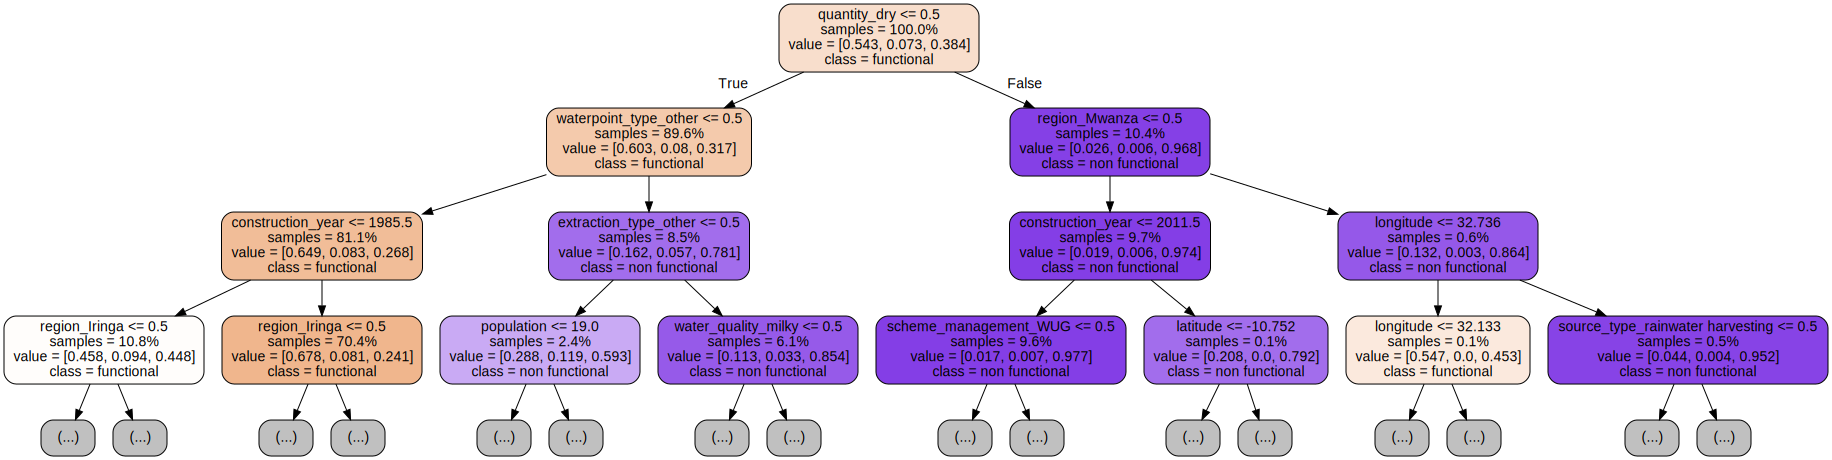

In [124]:
# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))



#SInce the first level is about quantity drive, that's the "most predictive" feature in this model.

In [131]:
# Increase "minimum node size" / min_samples_leaf, to reduce model complexity,
# This happens to improve validation accuracy here.

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=8, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val)) 

Train Accuracy 0.8472011784511785
Validation Accuracy 0.7765993265993266


In [94]:
y_pred = pipeline.predict(X_test)
y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [0]:
# Formatting submission
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-AndrewLowe4.csv', index = False)

- `amount_tsh` : Total static head (amount water available to waterpoint)
- `date_recorded` : The date the row was entered
- `funder` : Who funded the well
- `gps_height` : Altitude of the well
- `installer` : Organization that installed the well
- `longitude` : GPS coordinate
- `latitude` : GPS coordinate
- `wpt_name` : Name of the waterpoint if there is one
- `num_private` :  
- `basin` : Geographic water basin
- `subvillage` : Geographic location
- `region` : Geographic location
- `region_code` : Geographic location (coded)
- `district_code` : Geographic location (coded)
- `lga` : Geographic location
- `ward` : Geographic location
- `population` : Population around the well
- `public_meeting` : True/False
- `recorded_by` : Group entering this row of data
- `scheme_management` : Who operates the waterpoint
- `scheme_name` : Who operates the waterpoint
- `permit` : If the waterpoint is permitted
- `construction_year` : Year the waterpoint was constructed
- `extraction_type` : The kind of extraction the waterpoint uses
- `extraction_type_group` : The kind of extraction the waterpoint uses
- `extraction_type_class` : The kind of extraction the waterpoint uses
- `management` : How the waterpoint is managed
- `management_group` : How the waterpoint is managed
- `payment` : What the water costs
- `payment_type` : What the water costs
- `water_quality` : The quality of the water
- `quality_group` : The quality of the water
- `quantity` : The quantity of water
- `quantity_group` : The quantity of water
- `source` : The source of the water
- `source_type` : The source of the water
- `source_class` : The source of the water
- `waterpoint_type` : The kind of waterpoint
- `waterpoint_type_group` : The kind of waterpoint